In [1]:
# dependencies import
from common_dependencies import *
from sklearn.manifold import TSNE
#import model_versions as mv
logger = logging.getLogger(f'main.tsne')

2024-05-02 00:26:55.989510: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-05-02 00:26:56.028188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 00:26:56.393883: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# train params that can be easily changed
# paths for files with original data
MAX_VAL = 1000
CROP_SIZE = 4
CROP_STEP = 1
PATH_SAVE_RESULT = f'tsne/crop_size={CROP_SIZE}_crop_step={CROP_STEP}'
XSHIFT = 200

dataset_desc = {'run_1': (DatasetPartDescription(PATH_TO_DATA['run_1'],DataCrop(0,0,MAX_VAL,MAX_VAL),SlidingCrop(CROP_SIZE,CROP_STEP),XSHIFT),),
                'run_2': (DatasetPartDescription(PATH_TO_DATA['run_2'],DataCrop(0,0,MAX_VAL,MAX_VAL),SlidingCrop(CROP_SIZE,CROP_STEP),XSHIFT),)}

In [3]:
#входные и выходные данные
# reading
dataset = {'run_1':dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['run_1'])])),
           'run_2':dict(zip(['x','y','bin'], [np.array(list(gen)) for gen in chain_dataset_gens(dataset_desc['run_2'])]))}

# squueze datasets
for dataset_part_name, dataset_part in dataset.items():
    for data_part_name, data_part in dataset_part.items():
        if data_part_name == 'x':
            dataset[dataset_part_name][data_part_name] = data_part.reshape(data_part.shape[0],-1)
        if data_part_name == 'y':
            dataset[dataset_part_name][data_part_name] = data_part.reshape(data_part.shape[0],-1)

# displaying
logger.debug('\nDataset')
for dataset_part_name, dataset_part in dataset.items():
    logger.debug('|'*8+dataset_part_name+'|'*8)
    for data_part_name, data_part in dataset_part.items():
        logger.debug(f'{data_part_name}.shape: {data_part.shape}, max={np.max(data_part)}, min={np.min(data_part)}')

main ::      get_dataset_gen() :: start
main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 44.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 62.992
    The arr min before normalization: -61.968
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 4.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker._ndarray_utils :: extend_ndarray_for_crops_di

In [4]:
f'''rom skimage import measure
import seaborn as sns

x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA['run_1'])
# roll data across x axis
x_df = dw.roll_df(x_df, XSHIFT, 1)
y_df = dw.roll_df(y_df, XSHIFT, 1).map(lambda x: 1 if x>0 else 0)

y_arr = y_df.to_numpy()
y_arr_labeled = measure.label(y_arr, connectivity=1)

idx = [np.where(y_arr_labeled == label) for label in np.unique(y_arr_labeled) if label]

print(len(idx))

for arr in idx:
    print(len(arr))
    print(arr[0].shape)

plt.pcolormesh(y_arr)
plt.show()

plt.pcolormesh(y_arr_labeled, cmap = )
plt.show()

dw.draw_defects_map(y_df)
map_labeled = measure.label(y_df.to_numpy(), connectivity=1)
bboxes = [area.bbox for area in measure.regionprops(map_labeled)]
for bbox in bboxes:
    print(bbox)''';

In [5]:
test_x_data = np.concatenate([dataset['run_1']['x'], dataset['run_2']['x']], axis=0)
logger.debug(f'{test_x_data.shape=}')

PER = 140
RSTATE = 10
LRATE = 10
NITER = 2000

PATH_SAVE_RESULT+=f'/PER_{PER}/LRATE_{LRATE}/NITER_{NITER}'

X_embedded = TSNE(n_components=2, 
                  learning_rate=LRATE,
                  init='random', 
                  perplexity=PER,
                  random_state=RSTATE,
                  n_iter=NITER).fit_transform(test_x_data)

X_embedded = dw.normalize_data(X_embedded)
dataset['run_1']['tsne_res'] = X_embedded[:dataset['run_1']['x'].shape[0]]
dataset['run_2']['tsne_res'] = X_embedded[dataset['run_1']['x'].shape[0]:]

logger.debug(f'{X_embedded.shape=}')
logger.debug(f"{dataset['run_1']['tsne_res'].shape=}")
logger.debug(f"{dataset['run_2']['tsne_res'].shape=}")

main.tsne ::             <module>() :: test_x_data.shape=(90516, 1024)
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 14.943974494934082
    The arr min before normalization: -13.596734046936035
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.tsne ::             <module>() :: X_embedded.shape=(90516, 2)
main.tsne ::             <module>() :: dataset['run_1']['tsne_res'].shape=(44464, 2)
main.tsne ::             <module>() :: dataset['run_2']['tsne_res'].shape=(46052, 2)


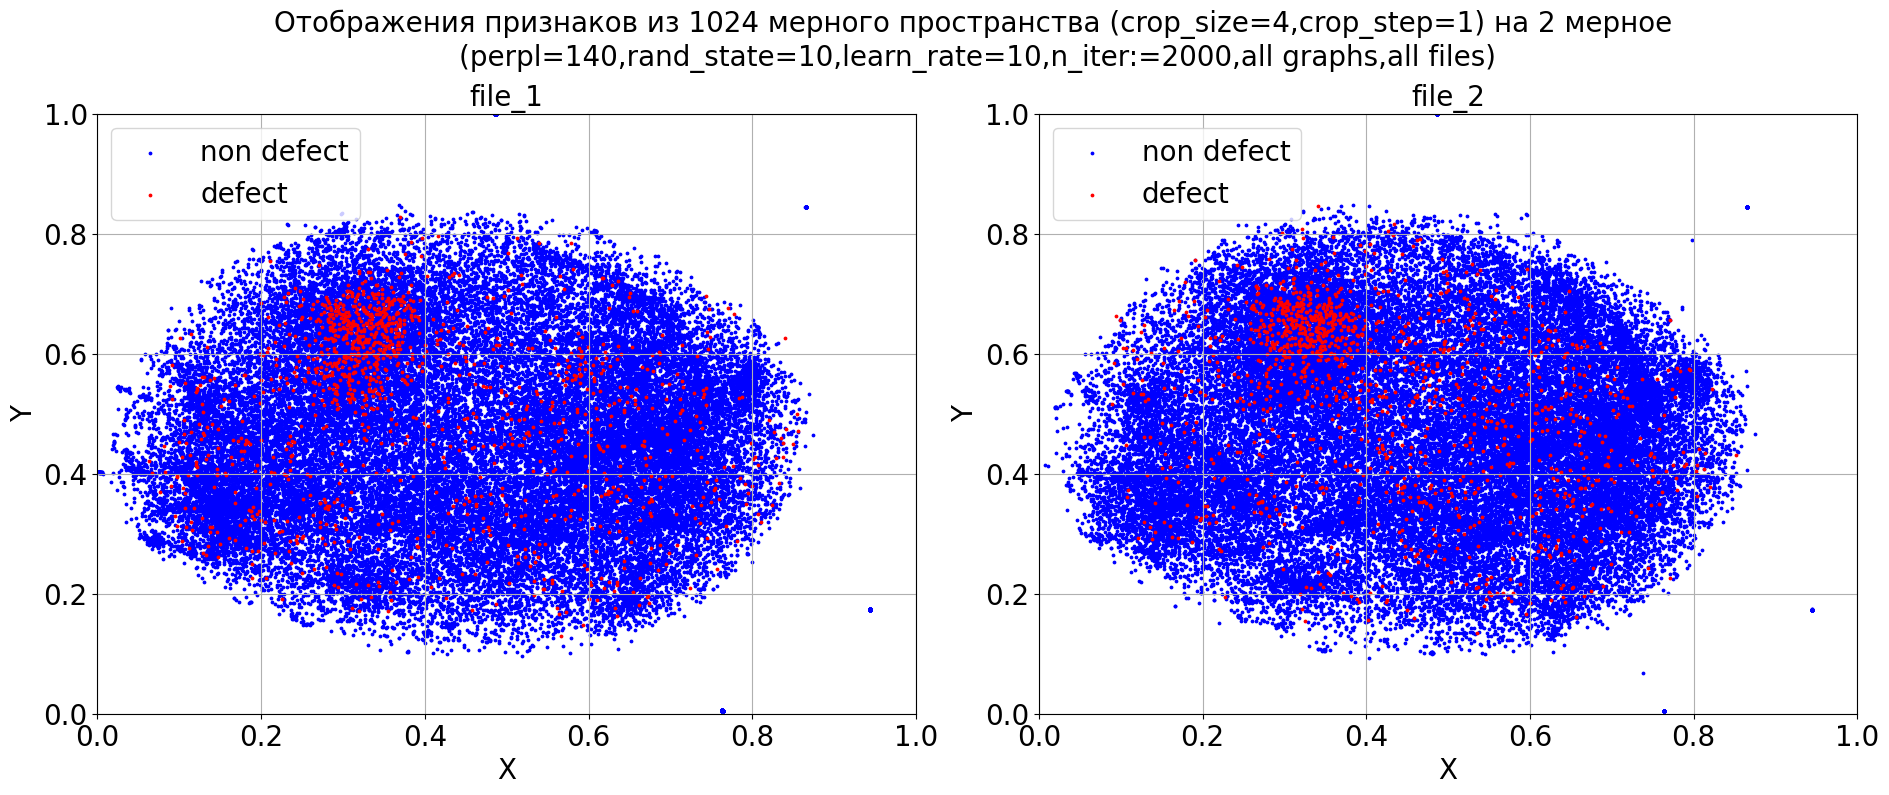

In [6]:
FONT_SIZE = 20
name = f"""Отображения признаков из {test_x_data.shape[1]} мерного пространства (crop_size={CROP_SIZE},crop_step={CROP_STEP}) на 2 мерное 
(perpl={PER},rand_state={RSTATE},learn_rate={LRATE},n_iter:={NITER},all graphs,all files)"""

fig, axes = plt.subplots(1,2)
fig.suptitle(name, fontsize=FONT_SIZE)
fig.set_figwidth(22)
fig.set_figheight(8)

axes[0].set_title('file_1', fontsize=FONT_SIZE)
axes[0].scatter(dataset['run_1']['tsne_res'][dataset['run_1']['bin']==0,0], dataset['run_1']['tsne_res'][dataset['run_1']['bin']==0,1], c='blue', s=3, label='non defect')
axes[0].scatter(dataset['run_1']['tsne_res'][dataset['run_1']['bin']!=0,0], dataset['run_1']['tsne_res'][dataset['run_1']['bin']!=0,1], c='red', s=3, label='defect')

axes[1].set_title('file_2', fontsize=FONT_SIZE)
axes[1].scatter(dataset['run_2']['tsne_res'][dataset['run_2']['bin']==0,0], dataset['run_2']['tsne_res'][dataset['run_2']['bin']==0,1], c='blue', s=3, label='non defect')
axes[1].scatter(dataset['run_2']['tsne_res'][dataset['run_2']['bin']!=0,0], dataset['run_2']['tsne_res'][dataset['run_2']['bin']!=0,1], c='red', s=3, label='defect')

for ax in axes:
    ax.set_xlabel('X',fontsize = FONT_SIZE)
    ax.set_ylabel('Y',fontsize = FONT_SIZE)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid(True)
    ax.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    ax.margins(0.05)
    ax.legend(fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.15, hspace=0.2)
name = name.replace("\n","")

if not os.path.exists(PATH_SAVE_RESULT):
    os.makedirs(PATH_SAVE_RESULT)
    
plt.savefig(f'{PATH_SAVE_RESULT}/{name}.jpeg', bbox_inches='tight')
plt.show()

In [9]:
mask = [True if (item[0]>=0.2 and item[0]<=0.4 and item[1]>=0.45 and item[1]<=0.75 and def_state!=0) else False 
         for item, def_state in zip(dataset['run_1']['tsne_res'], dataset['run_1']['bin'])]
dataset['run_1']['tsne_def_zone'] = dataset['run_1']['x'][mask]
dataset['run_1']['tsne_def_zone'] = dataset['run_1']['tsne_def_zone'].reshape(-1,CROP_SIZE,CROP_SIZE,64)
logger.debug(f"{dataset['run_1']['tsne_def_zone'].shape=} from total def: {dataset['run_1']['bin'][dataset['run_1']['bin']!=0].shape[0]}")

mask = [True if (item[0]>=0.2 and item[0]<=0.4 and item[1]>=0.55 and item[1]<=0.8 and def_state!=0) else False 
         for item, def_state in zip(dataset['run_2']['tsne_res'], dataset['run_2']['bin'])]
dataset['run_2']['tsne_def_zone'] = dataset['run_2']['x'][mask]
dataset['run_2']['tsne_def_zone'] = dataset['run_2']['tsne_def_zone'].reshape(-1,CROP_SIZE,CROP_SIZE,64)
logger.debug(f"{dataset['run_2']['tsne_def_zone'].shape=} from total def: {dataset['run_2']['bin'][dataset['run_2']['bin']!=0].shape[0]}")

main.tsne ::             <module>() :: dataset['run_1']['tsne_def_zone'].shape=(609, 4, 4, 64) from total def: 1315
main.tsne ::             <module>() :: dataset['run_2']['tsne_def_zone'].shape=(494, 4, 4, 64) from total def: 1316


In [10]:
def draw_choosen_defects(path_to_data, title, path_to_save, choosen_defects, xshift, crop_size, crop_step):
    x_df, y_df = dw.get_x_and_y_data(*path_to_data)

    x_df = dw.roll_df(x_df, xshift, 1)
    y_df = dw.roll_df(y_df, xshift, 1)
    
    x_arr = dw.df_to_numpy(x_df)
    y_arr = y_df.to_numpy()
    
    x_arr = np.concatenate([dw.normalize_data(x_arr[:,:,:32]), dw.normalize_data(x_arr[:,:,32:])],axis=2)
    y_arr = dw.normalize_data(y_arr)

    new_y_arr = np.zeros(y_arr.shape)
    print(f'{choosen_defects.shape=}')

    for i in range(0, x_arr.shape[0] - crop_size + 1, crop_step):  
        for j in range(0, x_arr.shape[1] - crop_size + 1, crop_step):  
            if np.sum(y_arr[i:i+crop_size, j:j+crop_size])>0:
                new_y_arr[i:i+crop_size, j:j+crop_size] = 1

    for i in range(0, x_arr.shape[0] - crop_size + 1, crop_step):  
        for j in range(0, x_arr.shape[1] - crop_size + 1, crop_step):  
            for item in choosen_defects:
                if (x_arr[i:i+crop_size, j:j+crop_size] == item).all():
                    new_y_arr[i:i+crop_size, j:j+crop_size] = 2
                    continue
                
    new_y_df =  pd.DataFrame(data=new_y_arr, index=y_df.index, columns=y_df.columns)

    dw.draw_defects_map(y_df, title=title, path_to_save=f'{path_to_save}/{title}')
    dw.draw_defects_map(new_y_df, title=title+' зеленый-все дефекты, желтый-дефект из зоны скопления',
                        path_to_save=f'{path_to_save}/{title} зеленый-все дефекты, желтый-дефект из зоны скопления')
                    

main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (115, 400)
    Read defect data shape: (115, 400)
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 44.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 62.992
    The arr min before normalization: -61.968
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 4.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0


choosen_defects.shape=(609, 4, 4, 64)


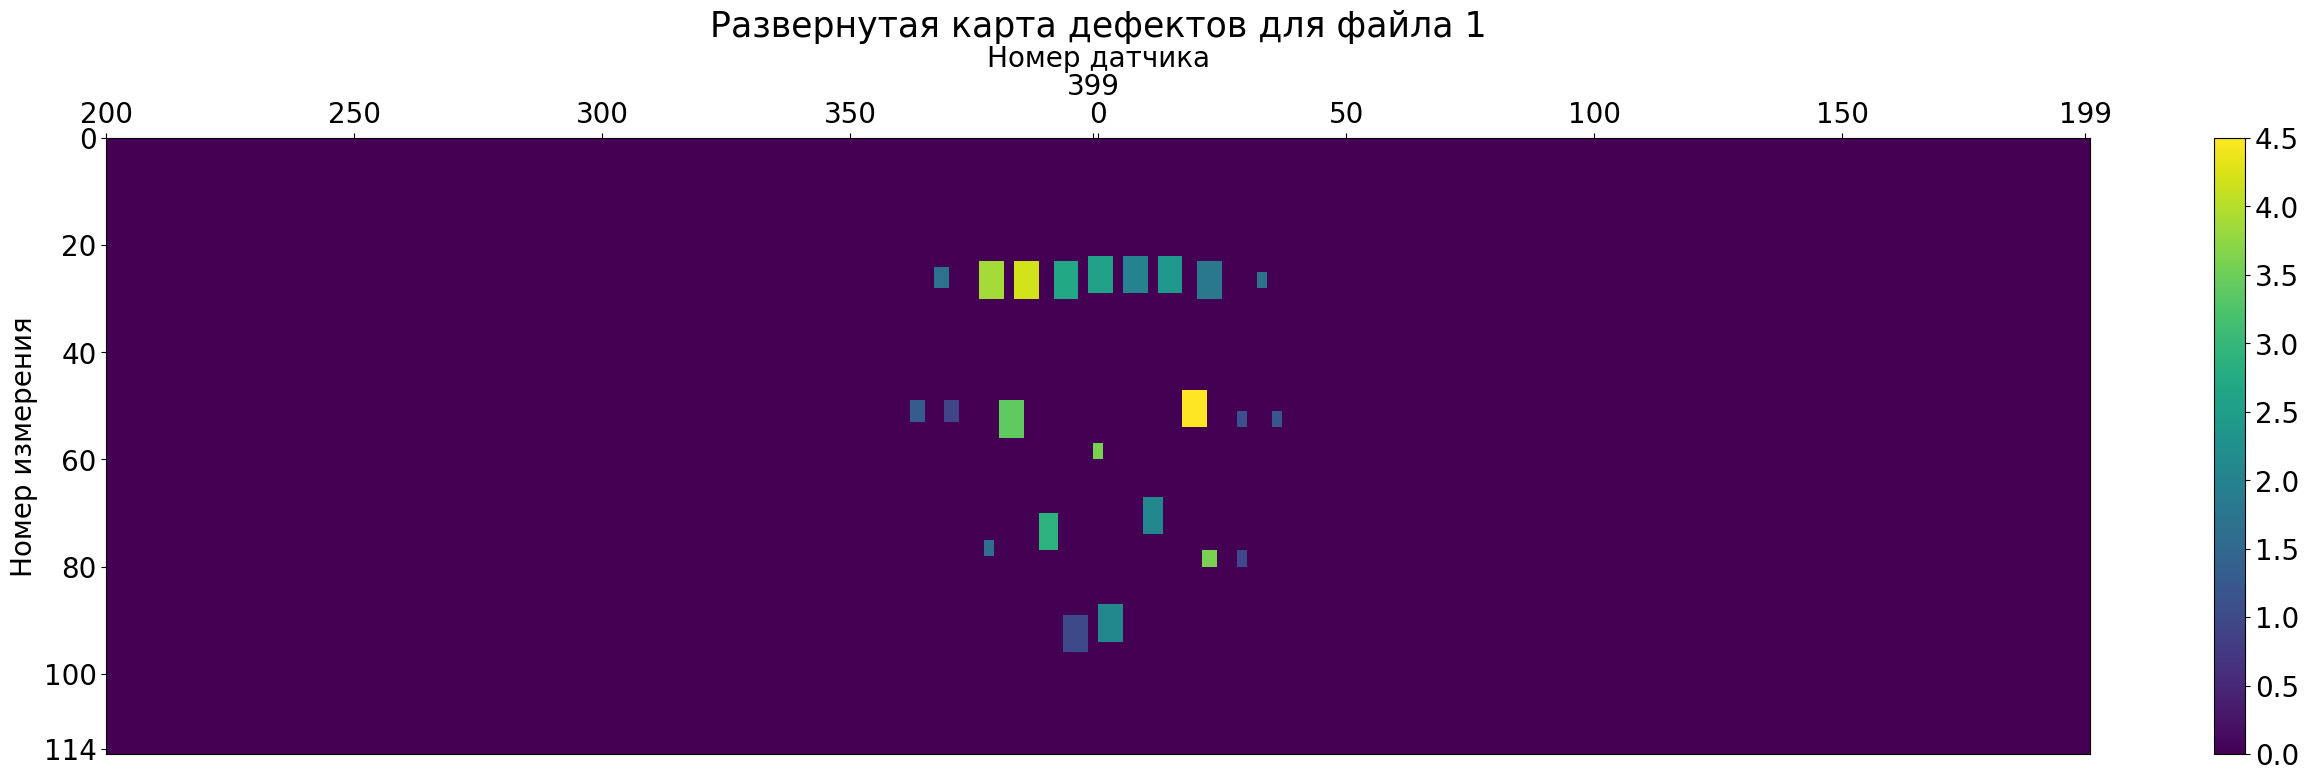

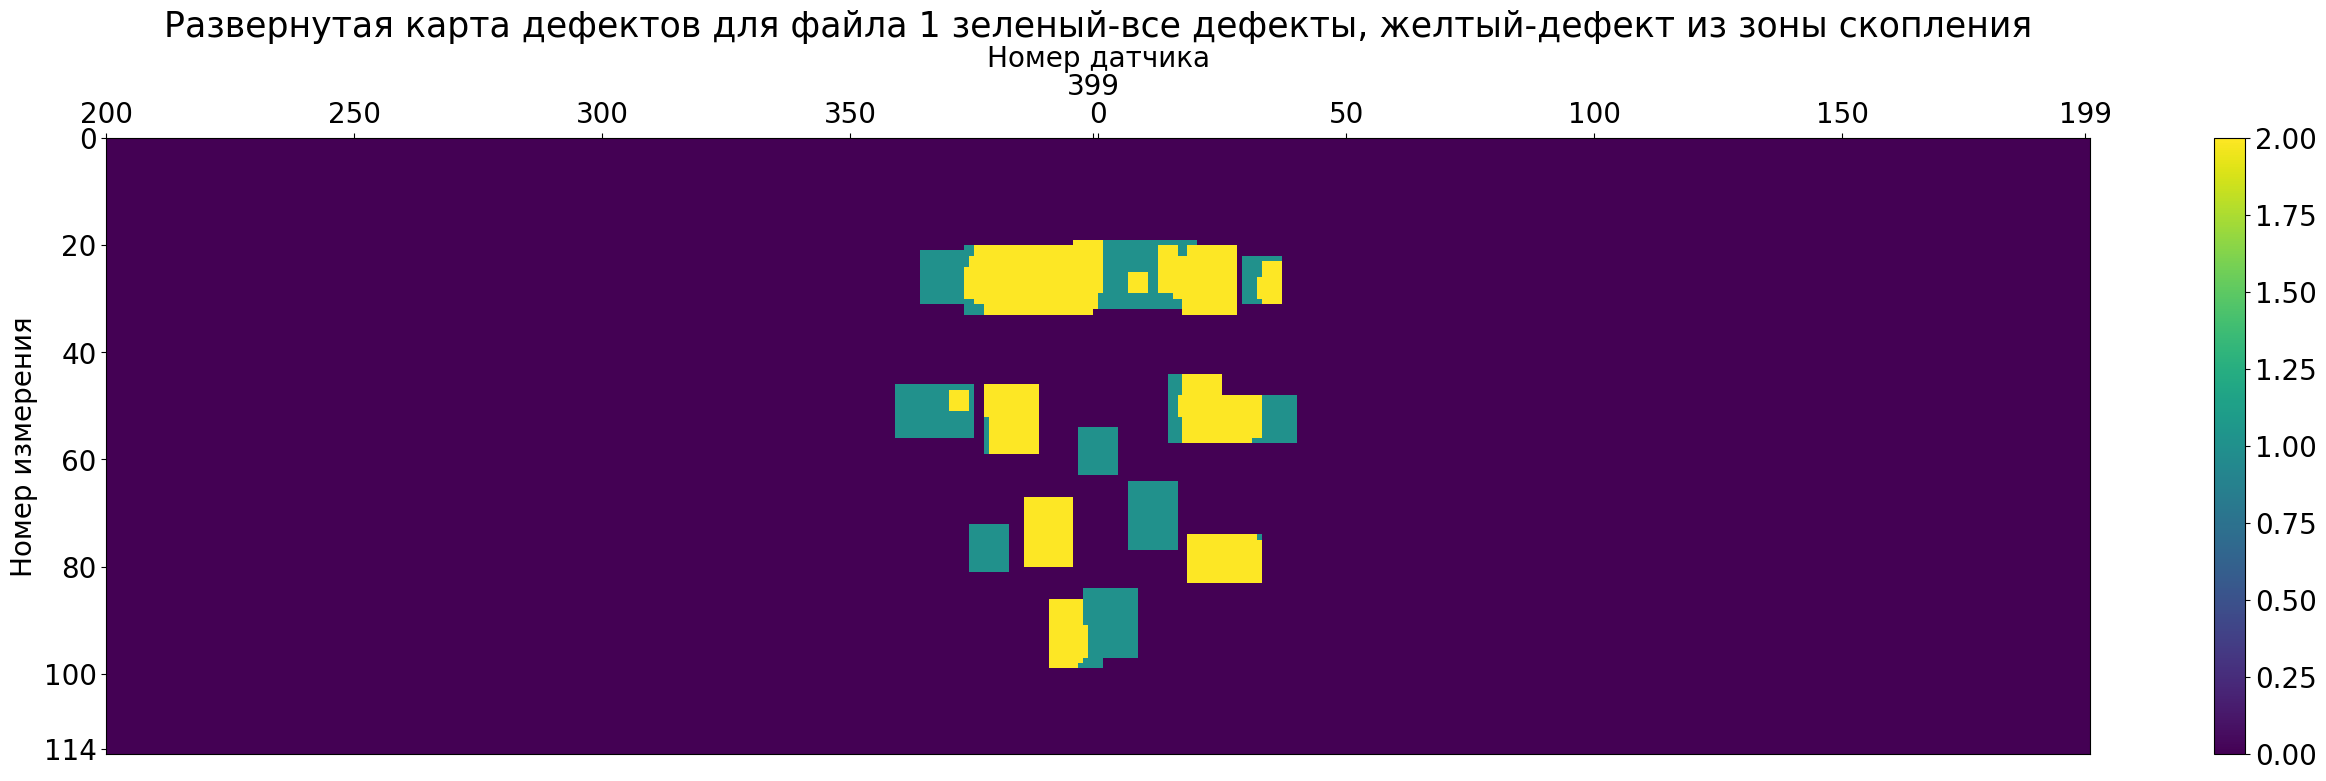

main.custom_modules.data_worker.data_worker ::     get_x_and_y_data() :: 
    Read detectors data shape: (119, 400)
    Read defect data shape: (119, 400)
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 44.4
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 62.992
    The arr min before normalization: -62.482
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0
main.custom_modules.data_worker.data_worker ::       normalize_data() :: 
    The arr max before normalization: 4.5
    The arr min before normalization: 0.0
    The arr max after normalization: 1.0
    The arr min after normalization: 0.0


choosen_defects.shape=(494, 4, 4, 64)


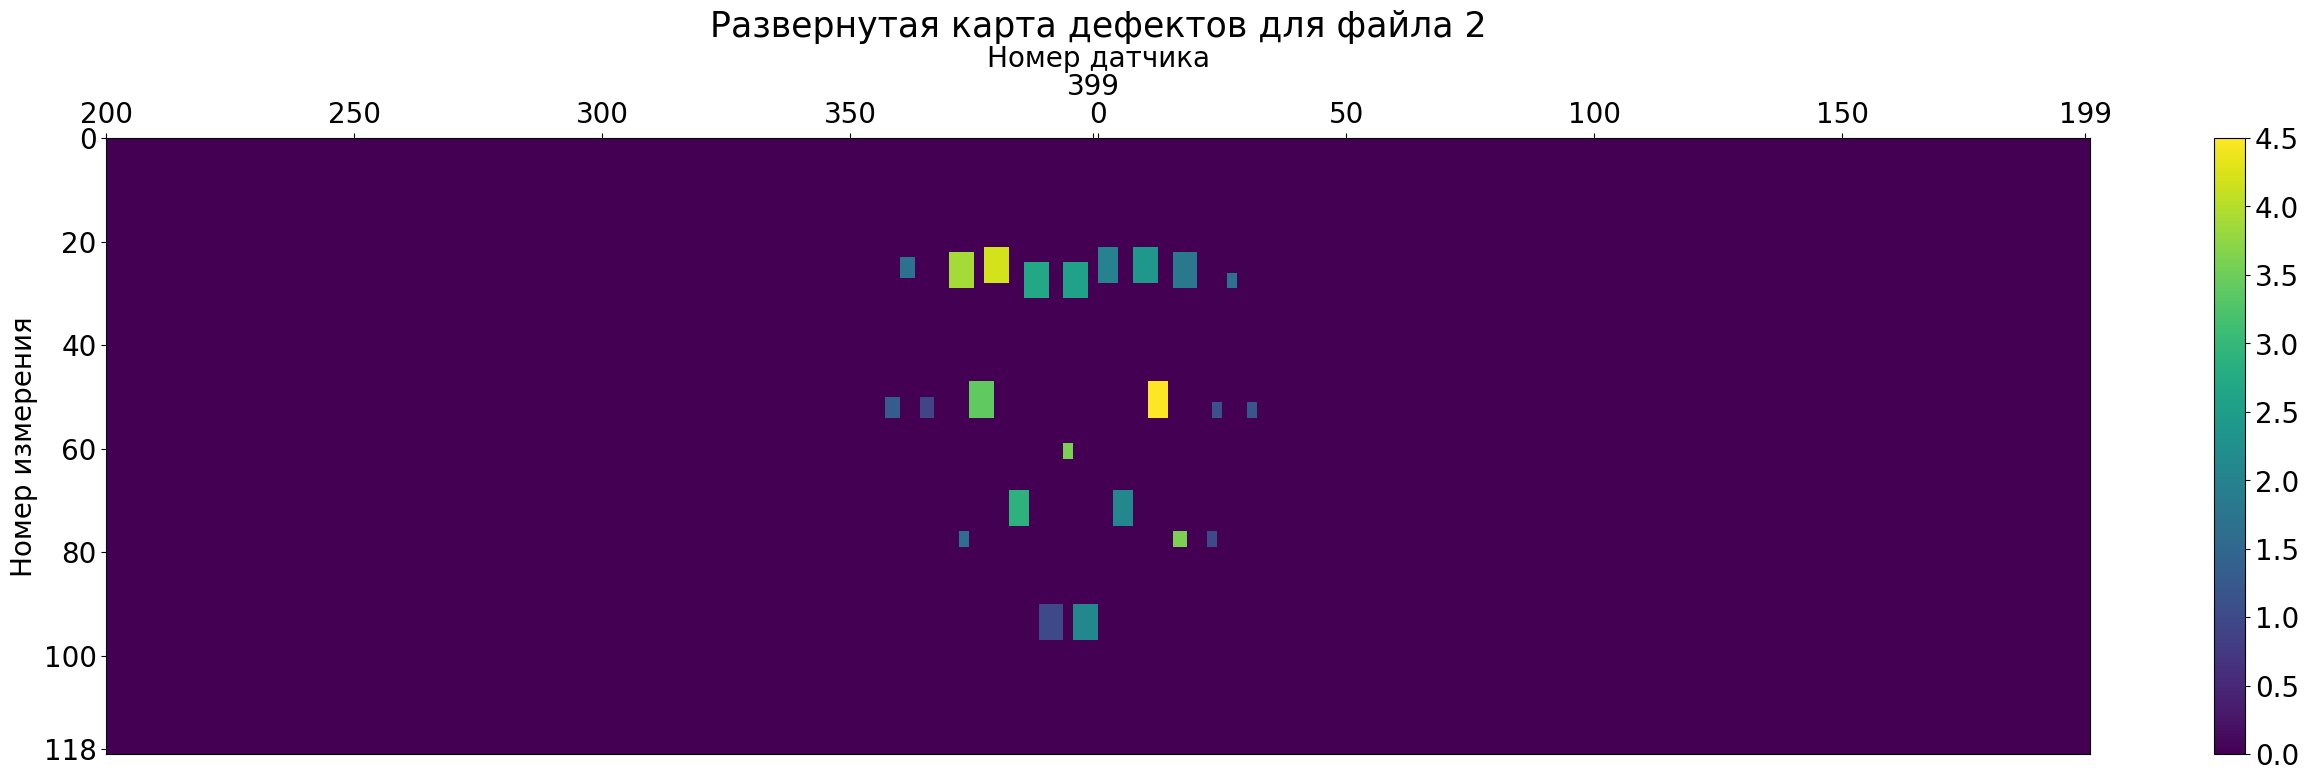

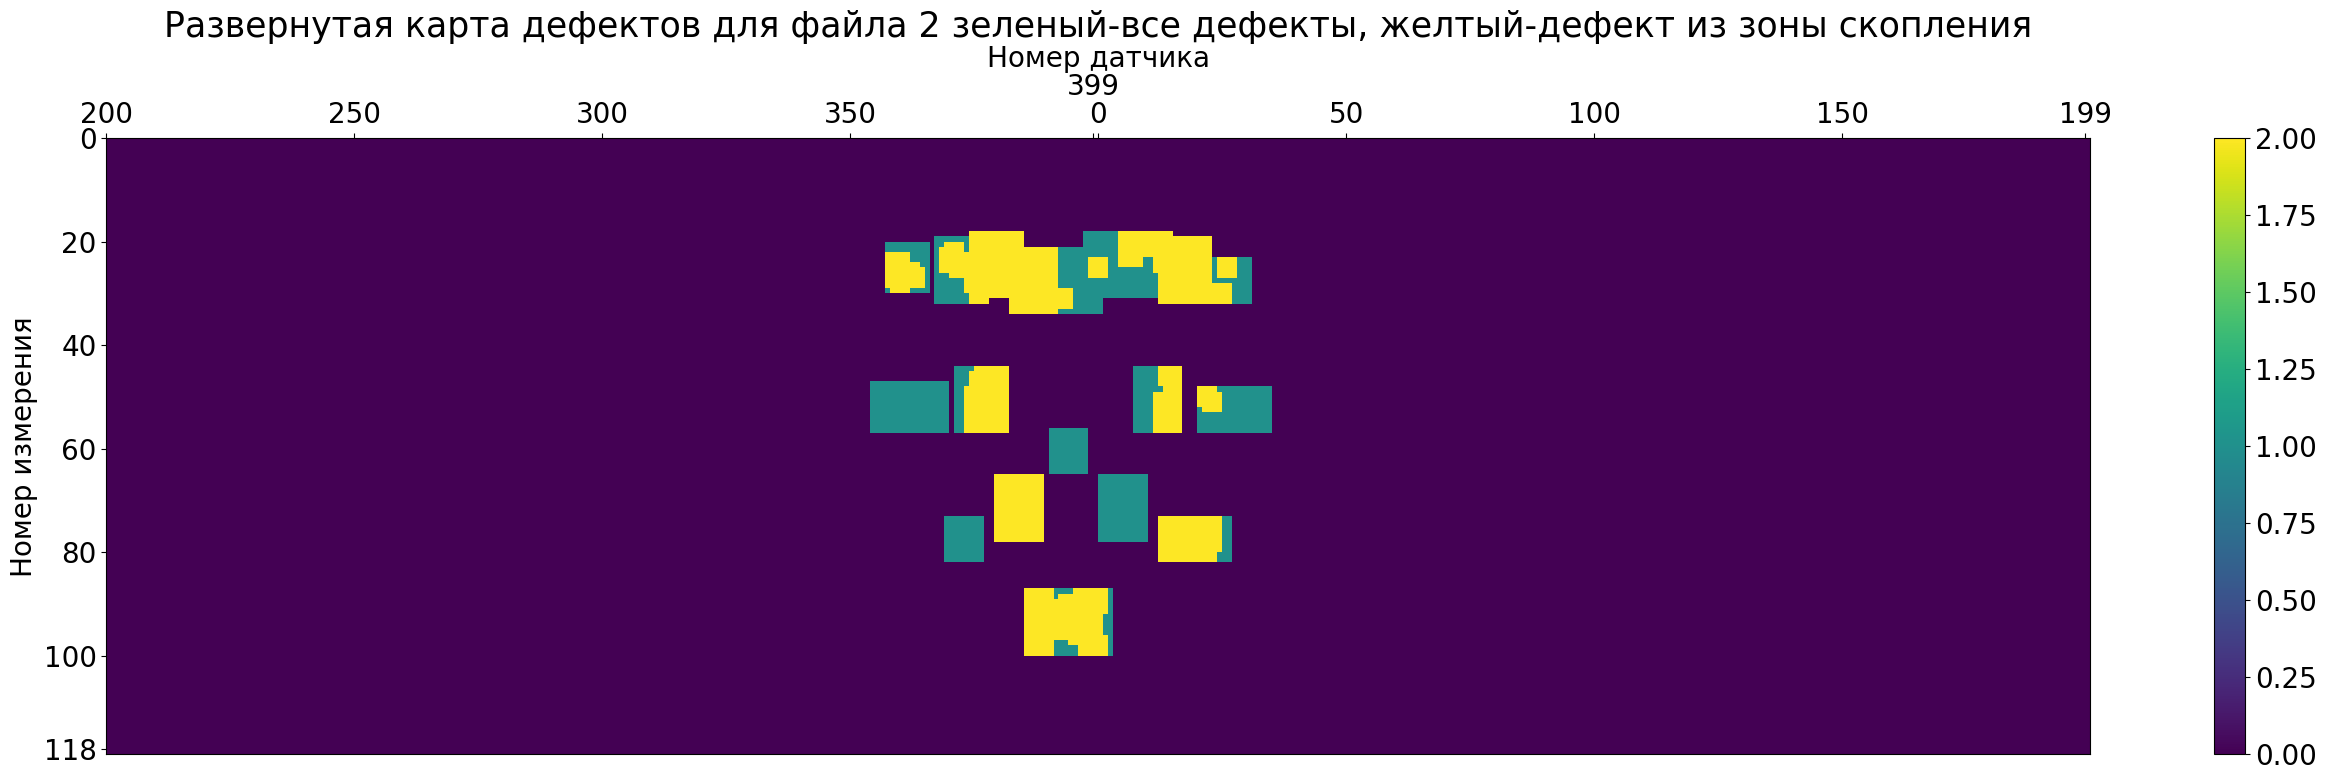

In [11]:
draw_choosen_defects(PATH_TO_DATA['run_1'], 'Развернутая карта дефектов для файла 1', PATH_SAVE_RESULT, dataset['run_1']['tsne_def_zone'], XSHIFT, CROP_SIZE, CROP_STEP)
draw_choosen_defects(PATH_TO_DATA['run_2'], 'Развернутая карта дефектов для файла 2', PATH_SAVE_RESULT, dataset['run_2']['tsne_def_zone'], XSHIFT, CROP_SIZE, CROP_STEP)

In [ ]:
'''plt.figure()
ax = plt.axes(projection ="3d")
# y_data==0 y_data!=0
name = f'Отображения признаков из {file_1_x.shape[1]} мерного пространства на 2 мерное (perpl: {PER}, rand_state: {RSTATE}, learn_rate: {LRATE}, n_iter: {NITER}, all graphs, file_1)'
plt.scatter(X_embedded[file_1_bin==0,0], X_embedded[file_1_bin==0,1], c='blue', s=1, label='non defect')
plt.scatter(X_embedded[file_1_bin!=0,0], X_embedded[file_1_bin!=0,1], c='red', s=1, label='defect')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title(name)
plt.grid(True)
#plt.savefig(f'tsne/{name}.jpeg', bbox_inches='tight')
plt.show()''';

In [ ]:
'''fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
#ax.scatter3D(X_embedded[file_1_bin==0,0], X_embedded[file_1_bin==0,1], X_embedded[file_1_bin==0,2], color = "blue", label='non defect')
#ax.scatter3D(X_embedded[file_1_bin!=0,0], X_embedded[file_1_bin!=0,1], X_embedded[file_1_bin!=0,2], color = "red", label='defect')
ax.scatter3D(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], color = "red", label='defect')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()''';

In [ ]:
'''plt.figure()
# y_data==0 y_data!=0
name = f'Отображения признаков из {test_x_data.shape[1]} мерного пространства на 2 мерное (perpl: {PER}, rand_state: {RSTATE}, learn_rate: {LRATE}, n_iter: {NITER}, all graphs, file_2)'
plt.scatter(X_embedded[file_1_x.shape[0]:,0], X_embedded[file_1_x.shape[0]:,1], c='red', s=1, label='file_2')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title(name)
plt.grid(True)
plt.savefig(f'tsne/{name}.jpeg', bbox_inches='tight')''';
#plt.show()

In [ ]:
#def1, nondef1 = file_1_x[file_1_y!=0], file_1_x[file_1_y==0] 
#print(f'{def1.shape=}, {nondef1.shape=}')